# Training models on campaigns in the same area 
## Operator 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM # type: ignore
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 18})

### Prossessing functions

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

### LSTM functions

In [4]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []

    for i in range(len(y_pred)):
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.abs(pred_series - true_series)


def long_short_term_memory(train, test, target_feature:str, features:list, campaigns:list, test_campaigns:list, n_steps_in=5, n_steps_out=1, n_first_units=5, n_second_units=10):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    # optimizer = RMSprop(learning_rate=0.001, rho=0.9) # , epsilon=None) 

    model = Sequential()
    model.add(LSTM(units=n_first_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=True, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(LSTM(units=n_second_units,
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    # model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam')
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    # prepare test data for plots
    if len(test_campaigns) == 1:
        y_pred = model.predict(X_test, verbose=0) 

        y_pred = scaler_pred.inverse_transform(y_pred)
        y_true = scaler_pred.inverse_transform(y_test)
        test[features] = scaler.inverse_transform(test[features])

        y_true_plot = test[target_feature].values
        y_pred_plot = np.empty_like(test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(test), :] = y_pred

        train_pred = model.predict(X, verbose=0)

        train_pred = scaler_pred.inverse_transform(train_pred)
        train[features] = scaler.inverse_transform(train[features])
        _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
        y_train_plot = train[target_feature].values
        train_pred_plot = np.empty_like(train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(train), :] = train_pred

    else:
        test_test = test[test['campaign'] == test_campaigns[0]]
        test_seq, test_test_seq = series_split_sequences(test_test, test_test[target_feature], n_steps_in, n_steps_out)
        y_pred = model.predict(test_seq, verbose=0)

        y_pred = scaler_pred.inverse_transform(y_pred)
        y_true = scaler_pred.inverse_transform(test_test_seq)
        test_test[features] = scaler.inverse_transform(test_test[features])

        y_true_plot = test_test[target_feature].values
        y_pred_plot = np.empty_like(test_test)
        y_pred_plot[:, :] = np.nan
        y_pred_plot[n_steps_in : len(test_test), :] = y_pred

        test_train = train[train['campaign'] == campaigns[0]]
        test_train_seq, test_y_seq = series_split_sequences(test_train, test_train[target_feature], n_steps_in, n_steps_out)
        train_pred = model.predict(test_train_seq, verbose=0)

        train_pred = scaler_pred.inverse_transform(train_pred)
        test_train[features] = scaler.inverse_transform(test_train[features])
        test_y_seq = scaler_pred.inverse_transform(test_y_seq)

        y_train_plot = test_train[target_feature].values
        train_pred_plot = np.empty_like(test_train)
        train_pred_plot[:, :] = np.nan
        train_pred_plot[n_steps_in : len(test_train), :] = train_pred

    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    results = {'y_pred': y_pred_plot,
               'y_true': y_true_plot,
               'train_pred': train_pred_plot,
               'train_true': y_train_plot,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results

### Random Forest functions

In [5]:
def rf(X_train, X_test, mode_train, mode_test, campaigns, test_campaigns, features, n_estimators=100, max_depth=None, min_samples_leaf=1):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    # rus = RandomUnderSampler() 
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])
    # X_train_balanced, mode_train_balanced = rus.fit_resample(X_train_balanced, mode_train_balanced)

    rf.fit(X_train_balanced, mode_train_balanced)

    if len(test_campaigns) == 1:
        y_pred = rf.predict(X_test[features])

        accuracy = accuracy_score(mode_test['Mode'], y_pred)
        precision = precision_score(mode_test['Mode'], y_pred)
        recall = recall_score(mode_test['Mode'], y_pred)

        y_true = mode_test['Mode']

        

        train_pred = rf.predict(X_train[features])

        train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
        train_precision = precision_score(mode_train['Mode'], train_pred)
        train_recall = recall_score(mode_train['Mode'], train_pred)

        train_true = mode_train['Mode']
    else:
        X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
        X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
        
        y_pred = rf.predict(X_test_test[features])

        y_pred_total = rf.predict(X_test[features])
        accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
        precision = precision_score(mode_test['Mode'], y_pred_total)
        recall = recall_score(mode_test['Mode'], y_pred_total)

        y_true = X_test_mode['Mode']

        X_train_test = X_train[X_train['campaign'] == campaigns[0]]
        X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

        train_pred = rf.predict(X_train_test[features])

        train_pred_total = rf.predict(X_train[features])
        train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
        train_precision = precision_score(mode_train['Mode'], train_pred_total)
        train_recall = recall_score(mode_train['Mode'], train_pred_total)

        train_true = X_train_mode['Mode']

    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'train_true': train_true,
               'train_pred': train_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'model': rf}
    return results

def plot_mode(pred, true, operator:str, comb:str, campaigns:list, test_campaigns:list, test_train='Test', colors=mode_colors):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    plt.plot(pred, color=colors[1], label='Predicted', zorder=2)
    plt.plot(true + 2, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.ylim((-0.2, 3.4))
    plt.yticks([0, 1, 2, 3], ['4G', '5G', '4G', '5G'])
    plt.title(f'{test_train} data -- {operator}\nParameters: {comb}\nn training campaigns: {len(campaigns)}, n testing campagns: {len(test_campaigns)}')
    plt.legend(ncols=3, loc='best')
    plt.show()

    return fig

In [6]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op2_merged.csv'
operator = 'Operator 2'

# LSTM
n_steps_in = 2
n_steps_out = 1

n_first_units = 5
n_second_units = 10

# Random Forest
n_estimators = 100
max_depth = 10

In [7]:
df = read_dataset(dataset)
campaigns = df['campaign'].unique().tolist()

In [8]:
fig = go.Figure()

for campaign in campaigns:
    current_route = df[df['campaign'] == campaign]
    fig.add_trace(go.Scattermapbox(lat=current_route['Latitude'], lon=current_route['Longitude'],
                                       marker = dict(
                                           opacity = 0.6,
                                           size = 3
                                       ),
                                       name=f'Route {campaigns.index(campaign)} - {operator}'))

fig.update_layout(
    height=420,
    mapbox=dict(
        style='carto-positron',
        zoom=11,
        center=dict(lon=df['Longitude'].mean(), lat=df['Latitude'].mean())
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
fig.show()
fig.write_image(format='pdf', file=r'../latex/plots/maps/op2_all_routes.pdf')

### Overlapping campaigns

- Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode, Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode, Capacity_Ookla_4G5G_Vodafone_Driving_Viale_Marconi, (Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode)

- Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia, Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight, Ping_8888_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight, Capacity_Ookla_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia__Test_2_No_Flight_Mode

- Ping_UNIDATA_4G5G_Vodafone_Walking_Fornetto_Durant_Gianicolense, Ping_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense_No_Flight, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense, (Ping_UNIDATA_4G5G_Vodafone_Driving_Vatican_Area_to_Sabino_Route_2_No_Flight_Mode), (Ping_8888_4G5G_Vodafone_Walkong_Sabino_to_Stat_Trastevere, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Sabino_to_Stat_Trastevere_Test_2)

- Ping_UNIDATA_4G5G_Vodafone_Driving_Luca, Interactivity_gaming_4G5G_Vodafone_Driving_Luca, Capacity_Ookla_4G5G_Vodafone_Driving_Luca

In [9]:

overlap_1 = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
             'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

overlap_2 = ['Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia', 
             'Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight', 
             'Ping_8888_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia__Test_2_No_Flight_Mode']

overlap_3 = ['Ping_UNIDATA_4G5G_Vodafone_Walking_Fornetto_Durant_Gianicolense', 
             'Ping_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense_No_Flight', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense', 
             'Ping_UNIDATA_4G5G_Vodafone_Driving_Vatican_Area_to_Sabino_Route_2_No_Flight_Mode', 
             'Ping_8888_4G5G_Vodafone_Walkong_Sabino_to_Stat_Trastevere', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Sabino_to_Stat_Trastevere_Test_2']

overlap_4 = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Luca', 
             'Interactivity_gaming_4G5G_Vodafone_Driving_Luca', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Luca']

In [10]:
train = read_dataset(dataset, campaigns=[overlap_1[1]])
test = read_dataset(dataset, campaigns=[overlap_1[0]])

campaigns = campaigns=train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

## LSTM

In [11]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [#['RSRP'], ['SINR'], ['RSRQ'], 
                     ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                     #['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                     ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ'], 
                     ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

lstm_results = {}

In [12]:
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            # print(used_features)
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, campaigns=campaigns, test_campaigns=test_campaigns, n_first_units=n_first_units, n_second_units=n_second_units)

In [13]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

Combination  loss_final  val_loss_final  \
0                         RSRP, SINR -> RSRP     0.00264         0.00110   
1                         RSRP, RSRQ -> RSRP     0.00276         0.00145   
2                   RSRP, SINR, RSRQ -> RSRP     0.00307         0.00195   
3                     RSRP, SSS_RSRP -> RSRP     0.00314         0.00174   
4                                All -> RSRP     0.00298         0.00187   
5                         RSRP, SINR -> SINR     0.00154         0.00042   
6                         SINR, RSRQ -> SINR     0.00116         0.00025   
7                   RSRP, SINR, RSRQ -> SINR     0.00144         0.00033   
8                     SINR, SSS_SINR -> SINR     0.00128         0.00018   
9                                All -> SINR     0.00134         0.00060   
10                        RSRP, RSRQ -> RSRQ     0.00264         0.00092   
11                        SINR, RSRQ -> RSRQ     0.00252         0.00106   
12                  RSRP, SINR, RSRQ -> RSRQ     0.00254         0.00102   
13                    RSRQ, SSS_RSRQ -> RSRQ     0.00296         0.00089   
14                               All -> RSRQ     0.00262         0.00095   
15            SSS_RSRP, SSS_SINR -> SSS_RSRP     0.00260         0.00285   
16            SSS_RSRP, SSS_RSRQ -> SSS_RSRP     0.00266         0.00284   
17  SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP     0.00265         0.00295   
18                RSRP, SSS_RSRP -> SSS_RSRP     0.00267         0.00294   
19                           All -> SSS_RSRP     0.00267         0.00299   
20            SSS_RSRP, SSS_SINR -> SSS_SINR     0.00343         0.00275   
21            SSS_SINR, SSS_RSRQ -> SSS_SINR     0.00334         0.00285   
22  SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_SINR     0.00346         0.00275   
23                SINR, SSS_SINR -> SSS_SINR     0.00343         0.00272   
24                           All -> SSS_SINR     0.00342         0.00296   
25            SSS_RSRP, SSS_RSRQ -> SSS_RSRQ     0.00334         0.00327   
26            SSS_SINR, SSS_RSRQ -> SSS_RSRQ     0.00332         0.00324   
27  SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRQ     0.00343         0.00322   
28                RSRQ, SSS_RSRQ -> SSS_RSRQ     0.00326         0.00340   
29                           All -> SSS_RSRQ     0.00343         0.00331   

     mae  train_mae  
0   1.02       0.52  
1   1.08       0.58  
2   1.41       0.74  
3   1.33       0.77  
4   1.30       0.71  
5   0.72       0.52  
6   0.48       0.41  
7   0.54       0.52  
8   0.56       0.45  
9   0.98       0.67  
10  0.24       0.26  
11  0.24       0.27  
12  0.26       0.28  
13  0.24       0.31  
14  0.30       0.30  
15  1.75       1.21  
16  1.58       1.11  
17  1.85       1.33  
18  1.78       1.26  
19  1.83       1.26  
20  1.92       1.29  
21  1.94       1.37  
22  1.86       1.23  
23  1.82       1.16  
24  2.04       1.38  
25  0.88       0.70  
26  0.82       0.69  
27  0.85       0.72  
28  0.85       0.71  
29  0.79       0.72

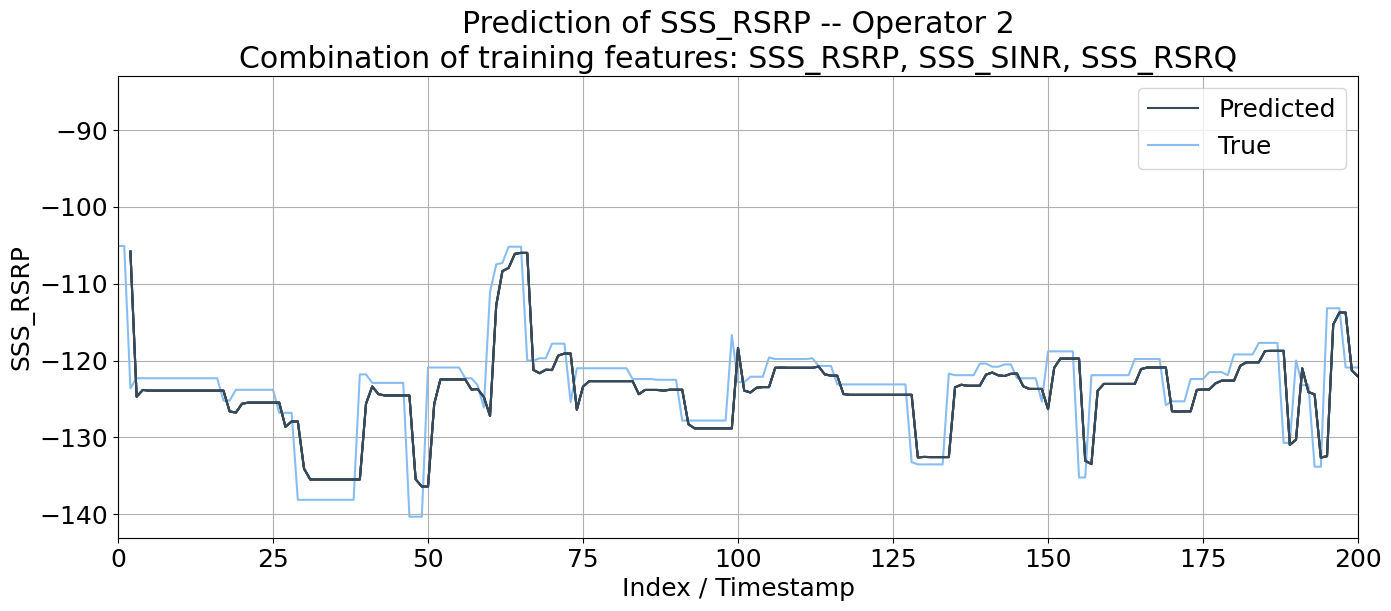

In [14]:
selected_sss_rsrp_comb = 'SSS_RSRP, SSS_SINR, SSS_RSRQ -> SSS_RSRP'
sss_rsrp_comb = lstm_results[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred']
sss_rsrp_true = sss_rsrp_comb['y_true']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred']
sss_rsrp_train_true = sss_rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of SSS_RSRP -- {operator}\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

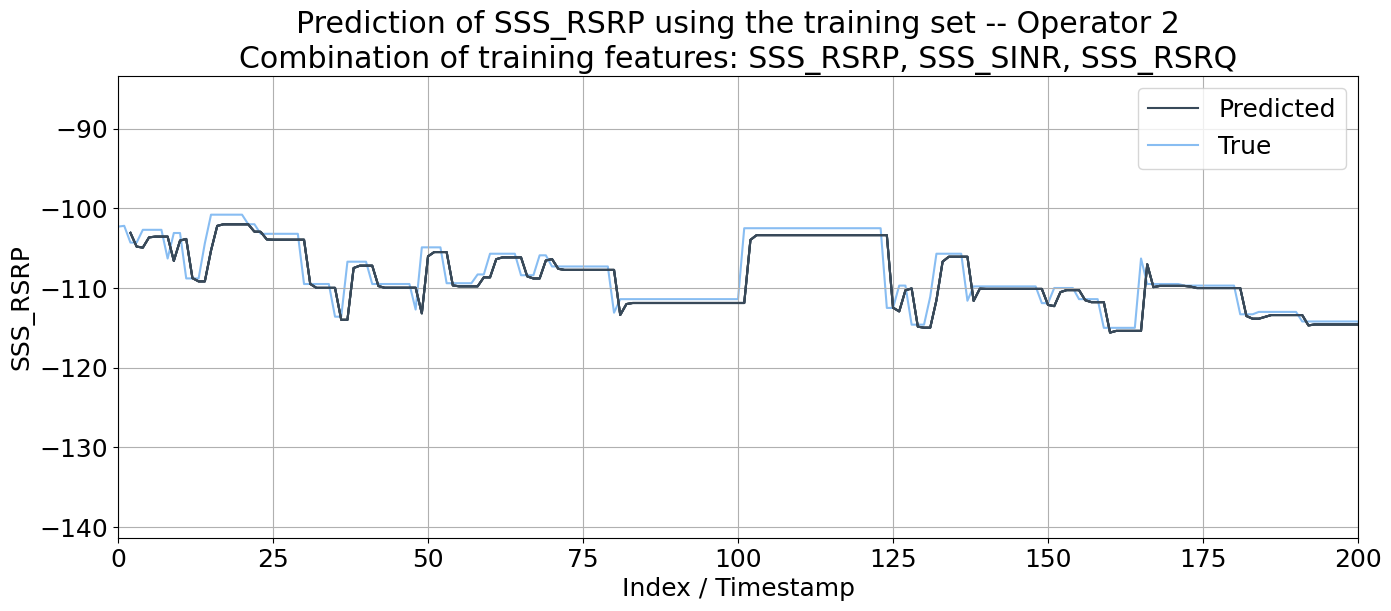

In [15]:
f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_train_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_train_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.xlim((0, 200))
plt.ylabel('SSS_RSRP')
plt.title(f'Prediction of SSS_RSRP using the training set -- {operator}\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

## Random Forest

In [16]:
est_try = [5, 10, 20, 50, 80, 100, 120, 150, 200, 250, 300]
min_leaf_size = [1, 2, 5, 7, 9, 12, 15]

### Overlap 1

#### Train 1 campaign -- Test 1 campaign

In [17]:
train = read_dataset(dataset, campaigns=[overlap_1[1]])
test = read_dataset(dataset, campaigns=[overlap_1[0]])

campaigns = campaigns=train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [18]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]
campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.638      0.821   0.587           0.997   
1      n_est: 5, min_leaf: 2     0.655      0.874   0.566           0.996   
2      n_est: 5, min_leaf: 5     0.619      0.842   0.529           0.992   
3      n_est: 5, min_leaf: 7     0.660      0.824   0.625           0.991   
4      n_est: 5, min_leaf: 9     0.639      0.829   0.581           0.987   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.659      0.868   0.578           0.996   
73   n_est: 300, min_leaf: 7     0.669      0.886   0.580           0.994   
74   n_est: 300, min_leaf: 9     0.664      0.894   0.565           0.993   
75  n_est: 300, min_leaf: 12     0.665      0.891   0.568           0.989   
76  n_est: 300, min_leaf: 15     0.664      0.892   0.567           0.988   

    Precision_train  Recall_train  
0             0.998         0.998  
1             0.995         0.998  
2             0.994         0.992  
3             0.991         0.994  
4             0.991         0.985  
..              ...           ...  
72            0.995         0.997  
73            0.992         0.997  
74            0.994         0.994  
75            0.990         0.990  
76            0.991         0.988  

[77 rows x 7 columns]

In [19]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.653
Mean precision: 0.868
Mean recall: 0.568


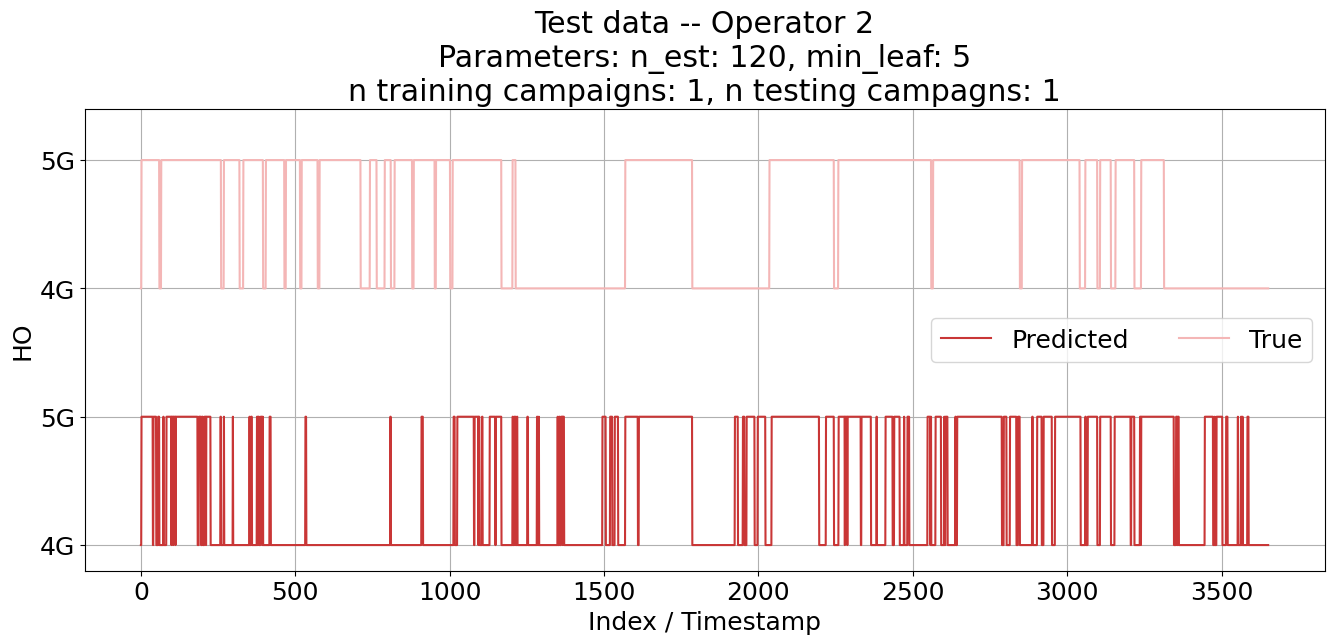

In [20]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf/op2_1_campaign_train.pdf')

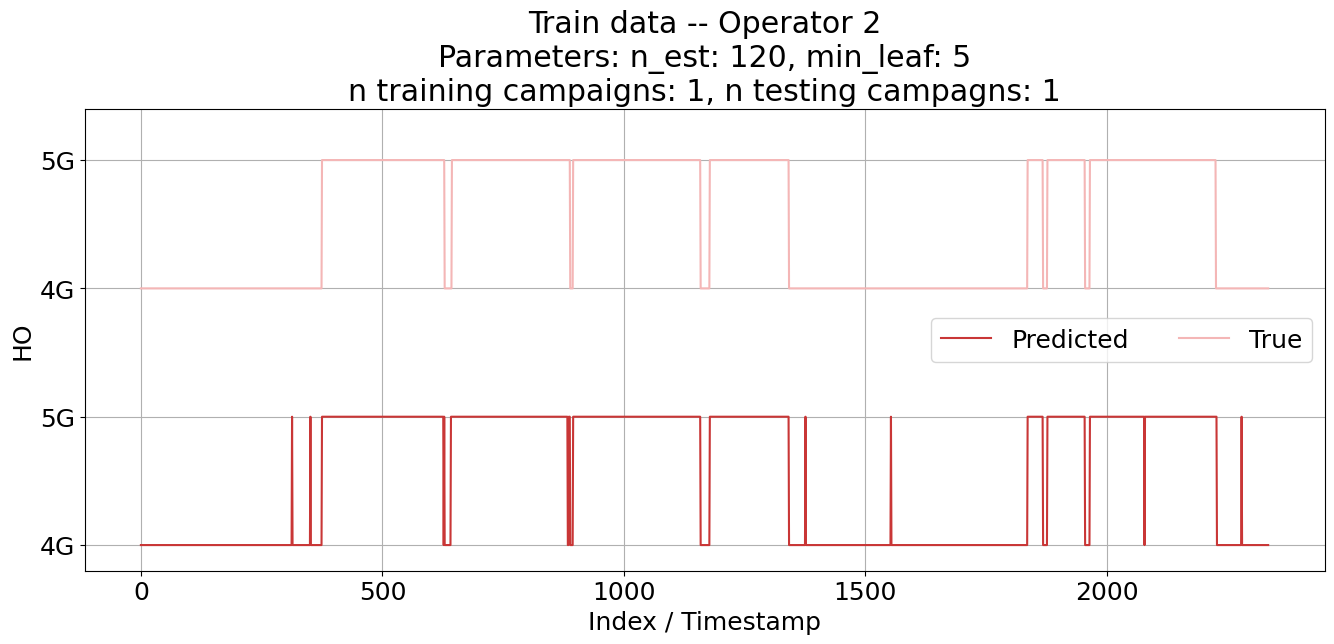

In [21]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true'].values

fig = plot_mode(pred=rf_pred_train, true=rf_true_train, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns, test_train='Train')
fig.savefig(r'../latex/plots/rf/op2_1_campaign_train_train.pdf')

#### Include location

In [22]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.777      0.942   0.711           1.000   
1      n_est: 5, min_leaf: 2     0.754      0.982   0.645           0.999   
2      n_est: 5, min_leaf: 5     0.874      0.950   0.857           0.994   
3      n_est: 5, min_leaf: 7     0.784      0.947   0.718           0.997   
4      n_est: 5, min_leaf: 9     0.735      0.956   0.634           0.997   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.771      0.985   0.667           0.997   
73   n_est: 300, min_leaf: 7     0.768      0.984   0.664           0.997   
74   n_est: 300, min_leaf: 9     0.762      0.970   0.664           0.997   
75  n_est: 300, min_leaf: 12     0.757      0.965   0.661           0.997   
76  n_est: 300, min_leaf: 15     0.767      0.977   0.668           0.997   

    Precision_train  Recall_train  
0             0.999         1.000  
1             0.999         0.999  
2             0.996         0.992  
3             0.996         0.998  
4             0.995         0.999  
..              ...           ...  
72            0.996         0.999  
73            0.996         0.999  
74            0.996         0.999  
75            0.996         0.999  
76            0.996         0.999  

[77 rows x 7 columns]

In [23]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.763
Mean precision: 0.973
Mean recall: 0.664


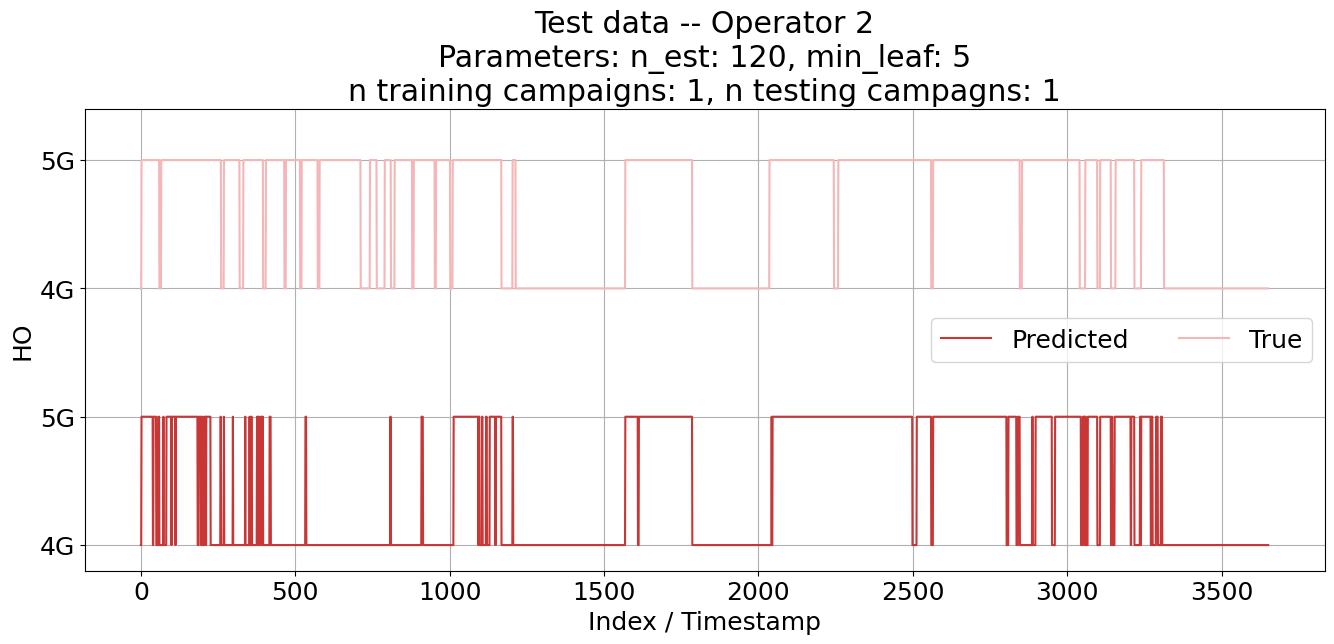

In [24]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf_loc/op2_1_campaign_train_lat_long.pdf')

#### Train 2 campaigns -- Test 1 campaign

In [25]:
train = read_dataset(dataset, campaigns=overlap_1[1:3])
test = read_dataset(dataset, campaigns=[overlap_1[0]])

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [26]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.591      0.785   0.535           0.999   
1      n_est: 5, min_leaf: 2     0.617      0.816   0.551           0.998   
2      n_est: 5, min_leaf: 5     0.664      0.854   0.601           0.994   
3      n_est: 5, min_leaf: 7     0.607      0.809   0.539           0.991   
4      n_est: 5, min_leaf: 9     0.663      0.868   0.586           0.989   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.671      0.912   0.562           0.997   
73   n_est: 300, min_leaf: 7     0.666      0.899   0.565           0.994   
74   n_est: 300, min_leaf: 9     0.670      0.900   0.571           0.992   
75  n_est: 300, min_leaf: 12     0.671      0.897   0.574           0.989   
76  n_est: 300, min_leaf: 15     0.670      0.910   0.562           0.987   

    Precision_train  Recall_train  
0             0.999         0.999  
1             0.999         0.997  
2             0.993         0.995  
3             0.993         0.988  
4             0.989         0.989  
..              ...           ...  
72            0.998         0.995  
73            0.994         0.994  
74            0.992         0.992  
75            0.987         0.991  
76            0.985         0.989  

[77 rows x 7 columns]

In [27]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.662
Mean precision: 0.892
Mean recall: 0.563


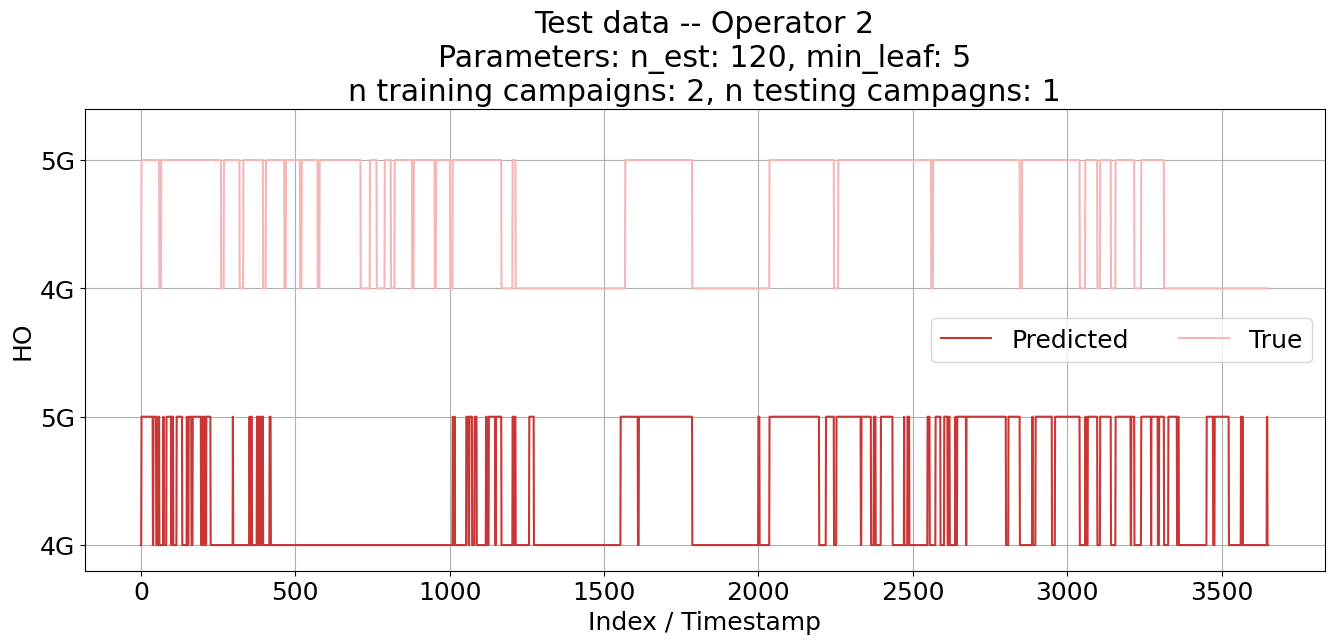

In [28]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf/op2_2_campaign_train.pdf')

#### Include location

In [29]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.757      0.946   0.676           0.999   
1      n_est: 5, min_leaf: 2     0.779      0.977   0.686           0.999   
2      n_est: 5, min_leaf: 5     0.732      0.946   0.635           0.996   
3      n_est: 5, min_leaf: 7     0.778      0.941   0.713           0.997   
4      n_est: 5, min_leaf: 9     0.754      0.960   0.659           0.997   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.761      0.986   0.652           0.999   
73   n_est: 300, min_leaf: 7     0.769      0.983   0.667           0.999   
74   n_est: 300, min_leaf: 9     0.764      0.979   0.661           0.998   
75  n_est: 300, min_leaf: 12     0.774      0.983   0.674           0.997   
76  n_est: 300, min_leaf: 15     0.777      0.986   0.676           0.996   

    Precision_train  Recall_train  
0             0.999         1.000  
1             0.999         0.999  
2             0.996         0.997  
3             0.997         0.997  
4             0.998         0.996  
..              ...           ...  
72            0.999         0.999  
73            0.999         0.999  
74            0.998         0.998  
75            0.996         0.997  
76            0.996         0.995  

[77 rows x 7 columns]

In [30]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.762
Mean precision: 0.978
Mean recall: 0.659


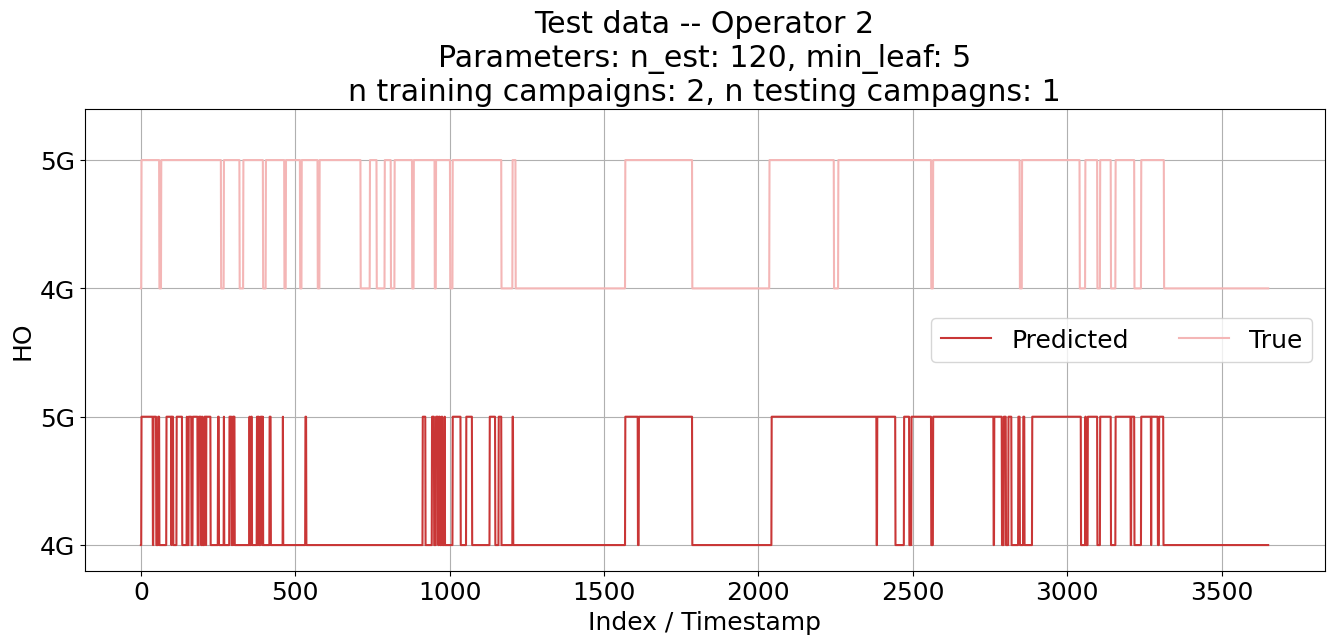

In [31]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf_loc/op2_2_campaign_train_lat_long.pdf')

#### Train 3 campaigns -- Test 1 campaign

In [32]:
route_to_add = read_dataset(dataset, campaigns=[overlap_1[3]])
df = pd.concat([route_to_add[5350::], train])
df.reset_index(drop=True, inplace=True)

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [33]:
fig = go.Figure()

for campaign in campaigns:
    current_route = train[train['campaign'] == campaign]
    fig.add_trace(go.Scattermapbox(lat=current_route['Latitude'], lon=current_route['Longitude'],
                                       marker = dict(
                                           opacity = 0.6,
                                           size = 3
                                       ),
                                       name=f'Route {campaigns.index(campaign)} - {operator}'))

fig.update_layout(
    height=420,
    mapbox=dict(
        style='carto-positron',
        zoom=12,
        center=dict(lon=train['Longitude'].mean(), lat=train['Latitude'].mean())
    ),
    margin=dict(
        t=1,
        b=1,
        r=1,
        l=1
    )
)
fig.show()
fig.write_image(format='pdf', file=r'../latex/plots/maps/op2.pdf')

In [34]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.append('campaign')
features = feature_selection[-1]

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.639      0.852   0.558           0.999   
1      n_est: 5, min_leaf: 2     0.638      0.854   0.553           0.998   
2      n_est: 5, min_leaf: 5     0.656      0.869   0.571           0.993   
3      n_est: 5, min_leaf: 7     0.636      0.826   0.578           0.990   
4      n_est: 5, min_leaf: 9     0.661      0.862   0.587           0.988   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.661      0.892   0.561           0.996   
73   n_est: 300, min_leaf: 7     0.662      0.890   0.564           0.994   
74   n_est: 300, min_leaf: 9     0.669      0.899   0.569           0.992   
75  n_est: 300, min_leaf: 12     0.676      0.910   0.573           0.989   
76  n_est: 300, min_leaf: 15     0.677      0.913   0.572           0.987   

    Precision_train  Recall_train  
0             0.999         0.999  
1             0.997         0.999  
2             0.996         0.989  
3             0.989         0.990  
4             0.989         0.986  
..              ...           ...  
72            0.998         0.995  
73            0.995         0.993  
74            0.991         0.993  
75            0.988         0.990  
76            0.984         0.988  

[77 rows x 7 columns]

In [35]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.662
Mean precision: 0.892
Mean recall: 0.563


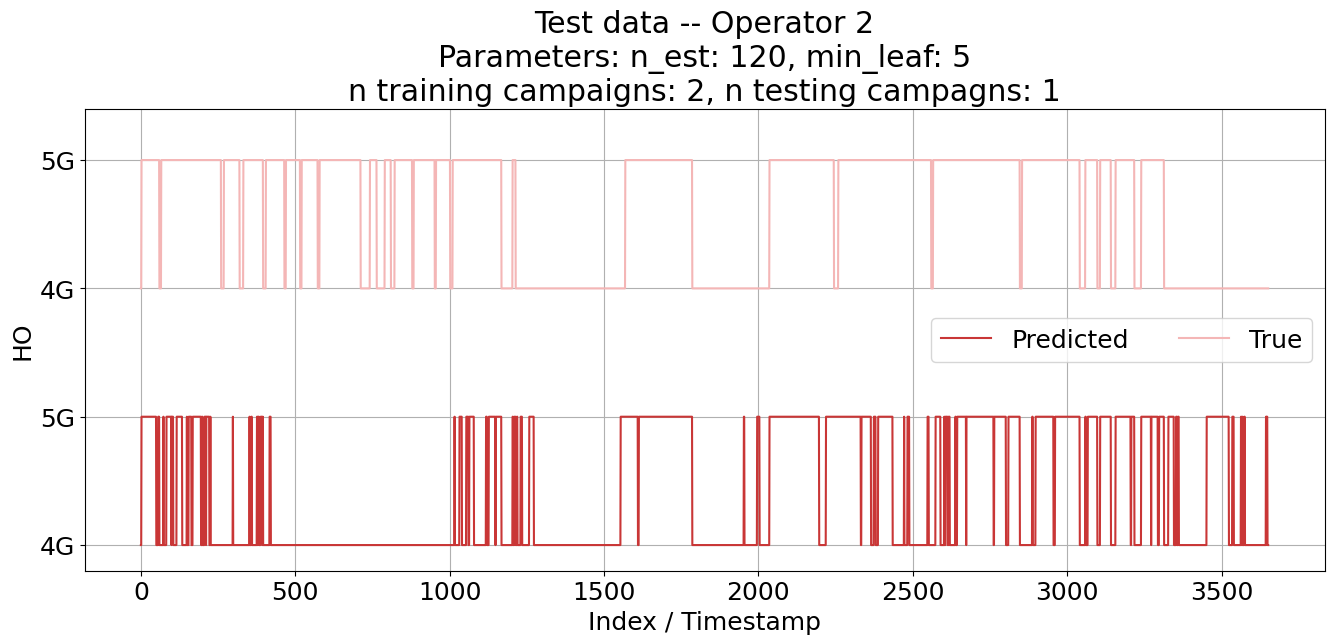

In [36]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf/op2_3_campaign_train.pdf')

#### Include location

In [37]:
rf_results = {}
feats = feature_selection[-1].copy()
feats.extend(['campaign', 'Latitude', 'Longitude'])
features = feature_selection[-1].copy()
features.extend(['Latitude', 'Longitude'])

for est in est_try:
    for leaf in min_leaf_size:
        rf_results[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=train['campaign'].unique().tolist(), test_campaigns=test['campaign'].unique().tolist(), n_estimators=est, min_samples_leaf=leaf, features=features)

df_rf_results = pd.DataFrame.from_dict(rf_results, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.738      0.943   0.648           0.999   
1      n_est: 5, min_leaf: 2     0.754      0.935   0.680           0.999   
2      n_est: 5, min_leaf: 5     0.733      0.980   0.613           0.998   
3      n_est: 5, min_leaf: 7     0.711      0.960   0.592           0.997   
4      n_est: 5, min_leaf: 9     0.766      0.948   0.688           0.996   
..                       ...       ...        ...     ...             ...   
72   n_est: 300, min_leaf: 5     0.769      0.985   0.664           0.999   
73   n_est: 300, min_leaf: 7     0.760      0.983   0.653           0.999   
74   n_est: 300, min_leaf: 9     0.762      0.980   0.657           0.996   
75  n_est: 300, min_leaf: 12     0.774      0.989   0.670           0.996   
76  n_est: 300, min_leaf: 15     0.769      0.984   0.665           0.995   

    Precision_train  Recall_train  
0             0.999         0.999  
1             1.000         0.998  
2             0.997         0.999  
3             0.996         0.998  
4             0.997         0.995  
..              ...           ...  
72            0.999         0.999  
73            0.999         0.999  
74            0.996         0.996  
75            0.996         0.996  
76            0.996         0.993  

[77 rows x 7 columns]

In [38]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.762
Mean precision: 0.977
Mean recall: 0.660


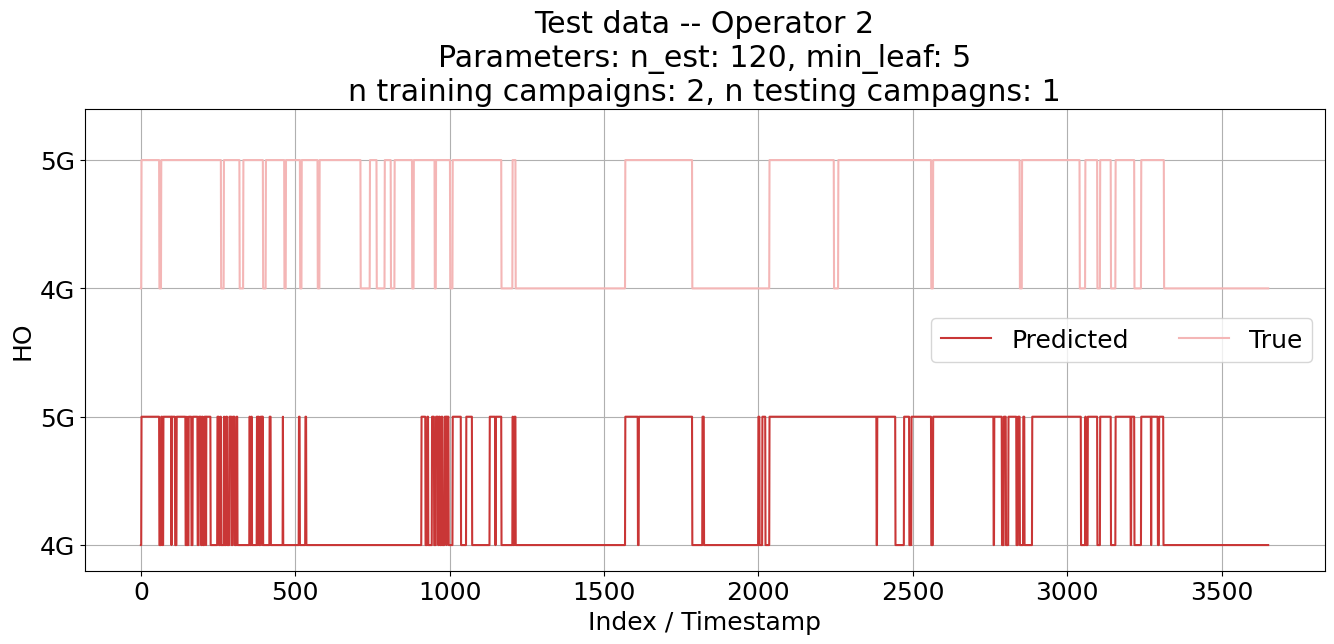

In [39]:
selected_rf_comb = 'n_est: 120, min_leaf: 5'
rf_comb = rf_results[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true'].values

fig = plot_mode(pred=rf_pred, true=rf_true, operator=operator, comb=selected_rf_comb, campaigns=campaigns, test_campaigns=test_campaigns)
fig.savefig(r'../latex/plots/rf_loc/op2_3_campaign_train_lat_long.pdf')